In [10]:
import torch
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt

In [88]:
torch.random.manual_seed(1325123)

In [89]:
src = 3
dst = 2
time_step = 1e-3

batch_size = 10

In [90]:
delays = torch.rand(dst, src, requires_grad=True)
delays = delays / 200
delays[0, 0] = 0
delays[1, 0] = 0
delays

tensor([[0.0000, 0.0049, 0.0003],
        [0.0000, 0.0034, 0.0016]], grad_fn=<CopySlices>)

In [91]:
w = torch.rand(dst, src)
bias = torch.rand(dst)

In [92]:
preact = (torch.rand(batch_size, src) > 0.5).float()
preact, preact.shape

(tensor([[0., 0., 0.],
         [0., 0., 1.],
         [1., 0., 1.],
         [1., 1., 1.],
         [1., 1., 0.],
         [0., 1., 1.],
         [1., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 0., 0.]]),
 torch.Size([10, 3]))

In [93]:
int_delays = (delays / time_step).long()
int_delays

tensor([[0, 4, 0],
        [0, 3, 1]])

In [94]:
binary_delays = F.one_hot(int_delays).unsqueeze(0)
binary_delays, binary_delays.shape

(tensor([[[[1, 0, 0, 0, 0],
           [0, 0, 0, 0, 1],
           [1, 0, 0, 0, 0]],
 
          [[1, 0, 0, 0, 0],
           [0, 0, 0, 1, 0],
           [0, 1, 0, 0, 0]]]]),
 torch.Size([1, 2, 3, 5]))

In [95]:
count = preact.unsqueeze(1).unsqueeze(-1) * binary_delays
count.shape

torch.Size([10, 2, 3, 5])

In [96]:
mask = count[..., 0].clone()
count[..., 0] = 0
# print(count)
# print()
# print(count[:, :, 0])
# print(count[:, :, 1])
# print(count[:, :, 2])
# print(count[:, :, 3])
# print()

count = torch.roll(count, -1, -1)
# print(count[:, :, 0])
# print(count[:, :, 1])
# print(count[:, :, 2])
# print(count[:, :, 3])

print(mask.shape, count.shape)
mask

torch.Size([10, 2, 3]) torch.Size([10, 2, 3, 5])


tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 1.],
         [0., 0., 0.]],

        [[1., 0., 1.],
         [1., 0., 0.]],

        [[1., 0., 1.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.]],

        [[0., 0., 1.],
         [0., 0., 0.]],

        [[1., 0., 1.],
         [1., 0., 0.]],

        [[0., 0., 1.],
         [0., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])

In [97]:
mw = mask * w.unsqueeze(0)
mwT = torch.transpose(mw, 1, 2)

mask.shape, preact.shape, w.shape, mw.shape, mwT.shape

(torch.Size([10, 2, 3]),
 torch.Size([10, 3]),
 torch.Size([2, 3]),
 torch.Size([10, 2, 3]),
 torch.Size([10, 3, 2]))

In [98]:
masked_linear = torch.vmap(F.linear, in_dims=(0, 0, None))
masked_linear(preact, mw, None).shape

torch.Size([10, 2])

In [99]:
out = preact.unsqueeze(1) @ mwT

print(preact.shape, mwT.shape, out.shape)
print(out)

torch.Size([10, 3]) torch.Size([10, 3, 2]) torch.Size([10, 1, 2])
tensor([[[0.0000, 0.0000]],

        [[0.6969, 0.0000]],

        [[0.8502, 0.8476]],

        [[0.8502, 0.8476]],

        [[0.1533, 0.8476]],

        [[0.6969, 0.0000]],

        [[0.8502, 0.8476]],

        [[0.6969, 0.0000]],

        [[0.1533, 0.8476]],

        [[0.0000, 0.0000]]])


In [100]:
out_test = []
for p, m in zip(preact, mask):
    # print(p)
    # print(m)
    mw = m * w
    # print(mw)

    u = p @ (mw.T)
    out_test.append(u)
    # print(u)
    # print()
out_test = torch.stack(out_test)
out_test, out_test.shape

(tensor([[0.0000, 0.0000],
         [0.6969, 0.0000],
         [0.8502, 0.8476],
         [0.8502, 0.8476],
         [0.1533, 0.8476],
         [0.6969, 0.0000],
         [0.8502, 0.8476],
         [0.6969, 0.0000],
         [0.1533, 0.8476],
         [0.0000, 0.0000]]),
 torch.Size([10, 2]))

# Time-Domain Response of Lock-in Filters

In [88]:
tau_c = 30e-3

In [89]:
def h(t, tau_c):
    return 1/tau_c * np.exp(-t / tau_c)* (t > 0).astype(float)

def hn(t, n, tau_c):
    scale = (1/tau_c*t)**(n-1)/ np.math.factorial(n-1) 
    return scale * h(t, tau_c)

In [90]:
t= np.linspace(0, 0.2, 2000)

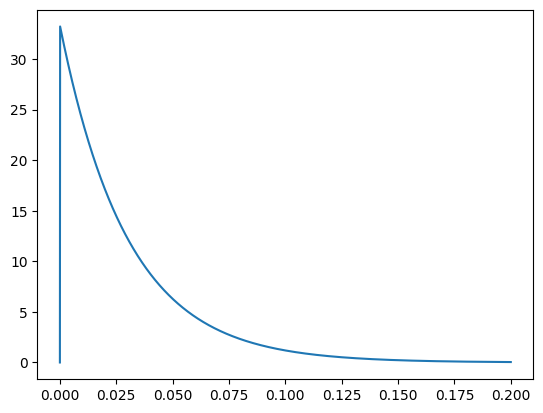

In [91]:
plt.plot(t, h(t, tau_c))

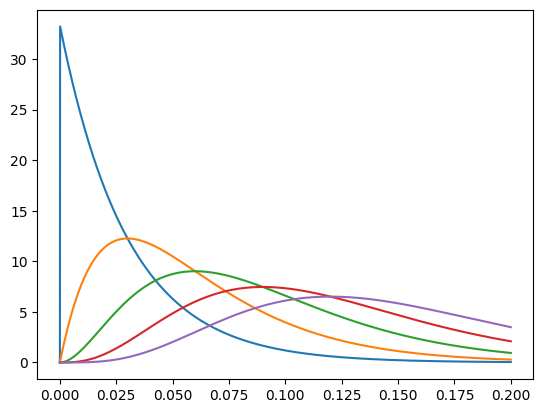

In [95]:
for n in range(1, 6):
    plt.plot(t, hn(t, n, tau_c))

In [101]:
delays.grad

/tmp/ipykernel_2027494/3770062022.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  delays.grad
